<a href="https://colab.research.google.com/github/MaryamNourii/EmotionDetection/blob/Fa/ED_SVM_LR_EDds_fa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

# feature extraction / vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

In [5]:
data = pd.read_csv('/content/CleanData_arman.csv', sep=',')

In [6]:
class_names = ['SAD', 'HATE', 'FEAR', 'ANGRY', 'HAPPY', 'SURPRISE', 'OTHER']
data['target'] = data['label'].map({'SAD':0, 'HATE':1, 'FEAR':2, 'ANGRY':3, 'HAPPY':4, 'SURPRISE':5, 'OTHER':6})
data_x = data['text']
data_y = data['target']

In [7]:
data['label'].value_counts(normalize=True)

SAD         0.177791
OTHER       0.176715
ANGRY       0.164719
HAPPY       0.135958
SURPRISE    0.132882
FEAR        0.123347
HATE        0.088588
Name: label, dtype: float64

In [8]:
train_x,test_x,train_y,test_y = train_test_split(data_x,data_y,test_size=0.2)
train_x,val_x,train_y,val_y = train_test_split(train_x,train_y,test_size=0.1)

In [9]:
print('size of training set: %s' % (len(train_x)))
print('size of test set: %s' % (len(test_x)))


size of training set: 4680
size of test set: 1301


In [10]:
def preprocess_and_tokenize(data):    

    #remove html markup
    data = re.sub("(<.*?>)", "", data)

    #remove urls
    data = re.sub(r'http\S+', '', data)
    
    #remove hashtags and @names
    data= re.sub(r"(#[\d\w\.]+)", '', data)
    data= re.sub(r"(@[\d\w\.]+)", '', data)

    #remove punctuation and non-ascii digits
    data = re.sub("(\\W|\\d)", " ", data)
    
    #remove whitespace
    data = data.strip()
    
    # tokenization with nltk
    data = word_tokenize(data)
    
    # stemming with nltk
    porter = PorterStemmer()
    stem_data = [porter.stem(word) for word in data]
        
    return stem_data

In [11]:
vect = TfidfVectorizer(tokenizer=preprocess_and_tokenize, sublinear_tf=True, norm='l2', ngram_range=(1, 2))

vect.fit_transform(train_x)

X_train_vect = vect.transform(train_x)
X_test_vect = vect.transform(test_x)

In [12]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),

           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Accuracy: 56.19%

F1 Score: 56.19

COnfusion Matrix:
 [[158   3   7  16  17   7  33]
 [ 20  69   2  15   5   2  17]
 [  9   0 109   5   1   6  11]
 [ 37   3   5 130   7  12  33]
 [ 40   1   4   5  78  13  34]
 [ 20   0   6  13   9  76  40]
 [ 51   6   7  20  22   6 111]]


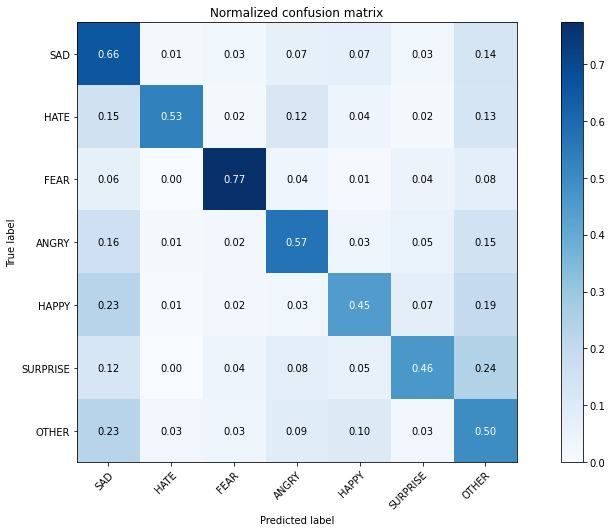

In [17]:
log = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=200)
log.fit(X_train_vect, train_y)

ylog_pred = log.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(test_y, ylog_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(test_y, ylog_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(test_y, ylog_pred))

plot_confusion_matrix(test_y, ylog_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [19]:
classification_report(test_y, ylog_pred)

'              precision    recall  f1-score   support\n\n           0       0.47      0.66      0.55       241\n           1       0.84      0.53      0.65       130\n           2       0.78      0.77      0.78       141\n           3       0.64      0.57      0.60       227\n           4       0.56      0.45      0.50       175\n           5       0.62      0.46      0.53       164\n           6       0.40      0.50      0.44       223\n\n    accuracy                           0.56      1301\n   macro avg       0.62      0.56      0.58      1301\nweighted avg       0.59      0.56      0.57      1301\n'

In [ ]:
              precision    recall  f1-score   support

           0       0.47      0.66      0.55       241
           1       0.84      0.53      0.65       130
           2       0.78      0.77      0.78       141
           3       0.64      0.57      0.60       227
           4       0.56      0.45      0.50       175
           5       0.62      0.46      0.53       164
           6       0.40      0.50      0.44       223

    accuracy                           0.56      1301
   macro avg       0.62      0.56      0.58      1301
weighted avg       0.59      0.56      0.57      1301


Accuracy: 57.19%

F1 Score: 57.19

COnfusion Matrix:
 [[142  10   9  18  25   8  29]
 [ 13  89   1  16   3   3   5]
 [  6   0 111   5   6   7   6]
 [ 24  10   7 130  12  21  23]
 [ 37   4   4   7  89  14  20]
 [ 15   2  10  13   9  84  31]
 [ 38  12   8  22  30  14  99]]


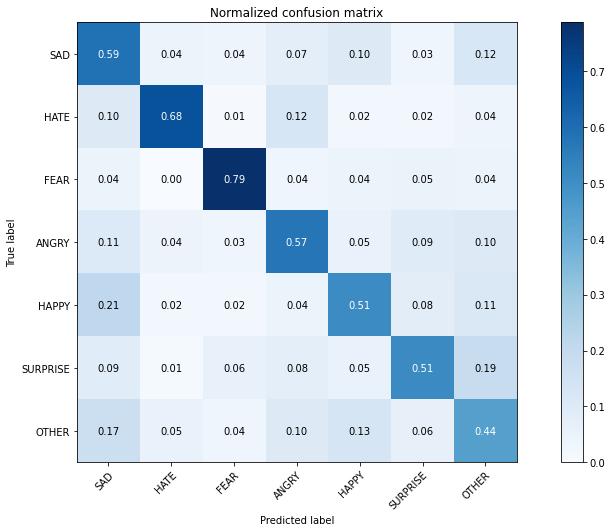

In [20]:
svc = LinearSVC(tol=1e-05)
svc.fit(X_train_vect, train_y)

ysvm_pred = svc.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(test_y, ysvm_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(test_y, ysvm_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(test_y, ysvm_pred))

plot_confusion_matrix(test_y, ysvm_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [24]:
classification_report(test_y, ysvm_pred)

'              precision    recall  f1-score   support\n\n           0       0.52      0.59      0.55       241\n           1       0.70      0.68      0.69       130\n           2       0.74      0.79      0.76       141\n           3       0.62      0.57      0.59       227\n           4       0.51      0.51      0.51       175\n           5       0.56      0.51      0.53       164\n           6       0.46      0.44      0.45       223\n\n    accuracy                           0.57      1301\n   macro avg       0.59      0.59      0.59      1301\nweighted avg       0.57      0.57      0.57      1301\n'

In [ ]:
              precision    recall  f1-score   support

           0       0.52      0.59      0.55       241
           1       0.70      0.68      0.69       130
           2       0.74      0.79      0.76       141
           3       0.62      0.57      0.59       227
           4       0.51      0.51      0.51       175
           5       0.56      0.51      0.53       164
           6       0.46      0.44      0.45       223

    accuracy                           0.57      1301
   macro avg       0.59      0.59      0.59      1301
weighted avg       0.57      0.57      0.57      1301
